# Look at climate change in MPI

## Imports

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
import xarray as xr
import warnings
import tqdm
import pathlib
import cmocean
import os

# Import custom modules
import src.utils
from src.XRO import XRO, xcorr

## set plotting specs
sns.set(rc={"axes.facecolor": "white", "axes.grid": False})

## bump up DPI
mpl.rcParams["figure.dpi"] = 100

## get filepaths
DATA_FP = pathlib.Path(os.environ["DATA_FP"])
SAVE_FP = pathlib.Path(os.environ["SAVE_FP"])

## Functions

In [2]:
def get_zonal_grad(x):
    """
    Function to compute zonal gradient. Ref: Fig 7 in Maher et al, 2023.
    """

    ## outlines for boxes
    ebox_coords = dict(longitude=slice(210, 270), latitude=slice(-5, 5))
    wbox_coords = dict(longitude=slice(120, 180), latitude=slice(-5, 5))

    ## compute box averages
    ebox_avg = src.utils.spatial_avg(x.sel(ebox_coords))
    wbox_avg = src.utils.spatial_avg(x.sel(wbox_coords))

    return ebox_avg - wbox_avg


def plot_hov(ax, data, amp, label=None):
    """Plot hovmoller of longitude vs. time"""

    # kwargs = dict(levels=src.utils.make_cb_range(3, 0.3), cmap="cmo.balance", extend="both")
    plot_data = ax.contourf(
        data.longitude,
        data.time.dt.year,
        data.T,
        cmap="cmo.balance",
        extend="both",
        levels=src.utils.make_cb_range(amp, amp / 10),
    )
    cb = fig.colorbar(
        plot_data, orientation="horizontal", ticks=[-amp, 0, amp], label=label
    )

    ## label
    kwargs = dict(ls="--", c="w", lw=0.8)
    for ax in axs:
        ax.set_xlabel("Longitude")
        ax.set_xticks([190, 240])
        ax.set_yticks([])
        ax.axvline(190, **kwargs)
        ax.axvline(240, **kwargs)
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position("top")

    return

## Load spatial data

In [3]:
## specify sliding window size for climatology
n_years = 3

## Load EOF data
eofs_fp = pathlib.Path(DATA_FP, "mpi", "eofs")
eofs_sst = src.utils.load_eofs(eofs_fp / "ts.nc")
eofs_ssh = src.utils.load_eofs(eofs_fp / "ssh.nc")

## for convenience, put components and scores into datasets
components = xr.merge(
    [eofs_sst.components().rename("sst"), eofs_ssh.components().rename("ssh")]
)
scores = xr.merge([eofs_sst.scores().rename("sst"), eofs_ssh.scores().rename("ssh")])

## get forced/anomalous component
forced, anom = src.utils.separate_forced(scores, n=n_years)

## Warming pattern over time

### Look at equatorial strip

In [4]:
## get rolling avg
forced_rolling = src.utils.get_rolling_avg(forced, n=1)

## get NDJ season
month = forced_rolling.time.dt.month
forced_ndj = forced_rolling.isel(time=(month == 10))

# ## reconstruct equatorial average
eq_avg = lambda x: x.sel(latitude=slice(-2, 2)).mean("latitude")
kwargs = dict(scores=forced_ndj, components=components, fn=eq_avg)
forced_ndj_recon = src.utils.reconstruct_fn(**kwargs).sel(longitude=slice(125, 280))

## subtract leading 30-year mean
forced_ndj_recon -= forced_ndj_recon.isel(time=slice(None, 30)).mean("time")

#### Hövöller plot

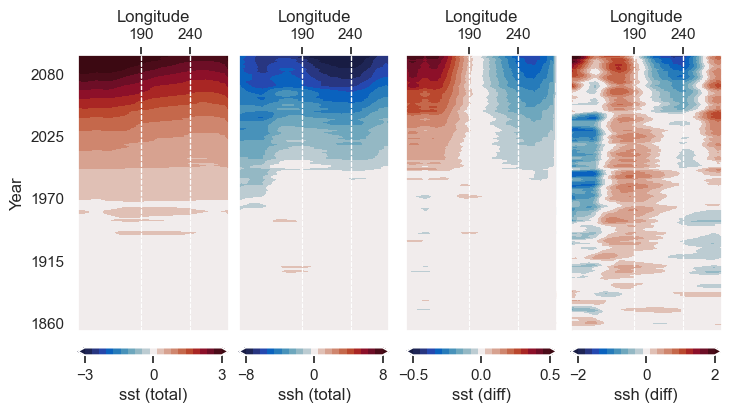

In [5]:
## setup plot
fig, axs = plt.subplots(1, 4, figsize=(7.2, 4), layout="constrained")

for j, (varname, total_amp, diff_amp) in enumerate(
    zip(["sst", "ssh"], [3, 8], [0.5, 2])
):

    ## get total plot and difference
    total = forced_ndj_recon[varname]
    diff = total - total.mean("longitude")

    ## plot data
    plot_hov(axs[j], total, amp=total_amp, label=f"{varname} (total)")
    plot_hov(axs[j + 2], diff, amp=diff_amp, label=f"{varname} (diff)")

axs[0].set_yticks(np.arange(1860, 2100, 55))
axs[0].set_ylabel("Year")
plt.show()

#### Line plots

## Change in zonal gradient

### Compute zonal gradient

In [6]:
## get subset of data to look at
anom_ = anom.sel(time=slice("1979", "2024"))

## compute zonal gradient at every time step
zonal_grad = src.utils.reconstruct_fn(components, anom_, fn=get_zonal_grad)

## get monthly avg
zonal_grad_by_month = zonal_grad.groupby("time.month").mean()

### Look at forced change

In [7]:
## compute zonal gradient
zonal_grad_forced = src.utils.reconstruct_fn(components, forced, fn=get_zonal_grad)

## reshape from time -> (month, year)
reshape = lambda x: x.reshape(12, -1, order="F")
zonal_grad_forced_by_month = reshape(zonal_grad_forced["sst"].values)

## subtract clim
clim = zonal_grad_forced_by_month[:, :30].mean(1, keepdims=True)
zonal_grad_change = zonal_grad_forced_by_month - clim

## get month, year dims
month = np.unique(forced.time.dt.month.values)
year = np.unique(forced.time.dt.year)

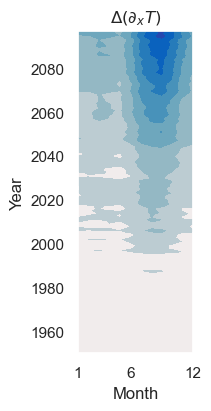

In [8]:
## setup plot
fig, ax = plt.subplots(figsize=(2, 4), layout="constrained")

## plot data
kwargs = dict(levels=src.utils.make_cb_range(1, 0.1), cmap="cmo.balance")
plot_data = ax.contourf(month, year, zonal_grad_change.T, **kwargs)

## label
ax.set_ylabel("Year")
ax.set_xlabel("Month")
ax.set_xticks([1, 6, 12])
ax.set_title(r"$\Delta \left(\partial_x T\right)$")
ax.set_ylim([1950, None])

plt.show()

## Look at mean state-dependence

### Compare Bjerknes growth rate to zonal gradient

#### Load $T,h$ data

In [9]:
## MPI data
mpi_load_fp = pathlib.Path(DATA_FP, "mpi_Th", "Th.nc")
Th = xr.open_dataset(mpi_load_fp)

#### Fit RO to $T,h$ data

In [10]:
## get subset of data
Th_sub = Th.sel(time=slice("1979", "2024"))

## initialize model
model = XRO(ncycle=12, ac_order=3, is_forward=True)

## fit to individual ensemble members
kwargs = dict(model=model, T_var="T_3", h_var="h_w", verbose=True)
_, fits = src.utils.get_RO_ensemble(Th_sub, **kwargs)

## extract parameters
params = model.get_RO_parameters(fits)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 16.20it/s]


#### Look at intra-ensemble spread
$\partial_x T$ vs. BJ index  
Compare to Maher et al (2023)

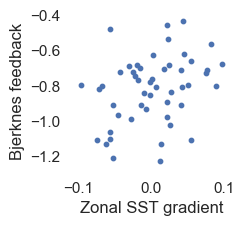

In [11]:
fig, ax = plt.subplots(figsize=(2, 2))
ax.scatter(zonal_grad_by_month["sst"].mean("month"), params["R"].mean("cycle"), s=10)
# ax.scatter(zonal_grad_by_month.sel(month=7), params["R"].sel(cycle=7), s=10)
ax.set_xlabel("Zonal SST gradient")
ax.set_ylabel("Bjerknes feedback")
plt.show()